In [1]:
import torch
import os
import subprocess

repo_root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip()
os.chdir(repo_root)

print("cwd =", os.getcwd())

from solvers.torch_eit_fem_solver import EIT
from solvers.torch_eit_fem_solver.fem import Mesh, V_h, dtn_map
from solvers.torch_eit_fem_solver.utils import dtn_from_sigma
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import cmocean as cmo
from scipy import io as sio
from tqdm import tqdm
from models.unet import Unet
from collections import OrderedDict
import numpy as np

device = 'cuda:1' 

train_dataset = torch.load('data/eit-circles-dtn-default-128.pt', map_location="cpu")

data_root = 'mesh-data'
mesh_file = 'mesh_128_h05.mat'
mat_fname = os.path.join(data_root, mesh_file)
mat_contents = sio.loadmat(mat_fname)

p = torch.tensor(mat_contents['p'], dtype=torch.float64).to(device)
t = torch.tensor(mat_contents['t']-1, dtype=torch.long).to(device)
vol_idx = torch.tensor(mat_contents['vol_idx'].reshape((-1,))-1, dtype=torch.long).to(device)
bdy_idx = torch.tensor(mat_contents['bdy_idx'].reshape((-1,))-1, dtype=torch.long).to(device)

mesh = Mesh(p, t, bdy_idx, vol_idx)
v_h = V_h(mesh)

dtn_background = dtn_from_sigma(sigma_vec=torch.ones(128, 128), v_h=v_h, mesh=mesh, img_size=128, device=device).cpu()

train_X = train_dataset['train']['dtn_map'].float()
train_X /= dtn_background
train_Y = train_dataset['train']['media'].float()

train_X_min = train_X.min()
train_X_max = train_X.max()
train_Y_min = train_Y.min()
train_Y_max = train_Y.max()

cwd = /home/johnma/flow-inverse


In [ ]:
from models.unet import UnetNoTime
model = UnetNoTime(ch=32).to(device)
checkpoint = torch.load("saved_runs/circles-eit-inverse-unet-default-bg-transform/checkpoints/ckp_37750.tar", map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'saved_runs/circles-eit-inverse-unet-default-bgt-sig_t/checkpoints/ckp_50250.tar'

In [3]:
tubes_data = torch.load('data/eit-tubes-dtn-default-128.pt', map_location='cpu')

test_ood_X = tubes_data['test']['dtn_map'].detach().clone().float()

test_ood_X /= dtn_background

test_ood_X = 2.0 * (test_ood_X - train_X_min) / (train_X_max - train_X_min + 1e-12) - 1.0

if test_ood_X.ndim == 3:
    test_ood_X = test_ood_X.unsqueeze(1)

OOD Relative L2 Error Statistics:
Mean: 0.2252
Std:  0.0619
Min:  0.0763
Max:  0.4131
Median: 0.2268


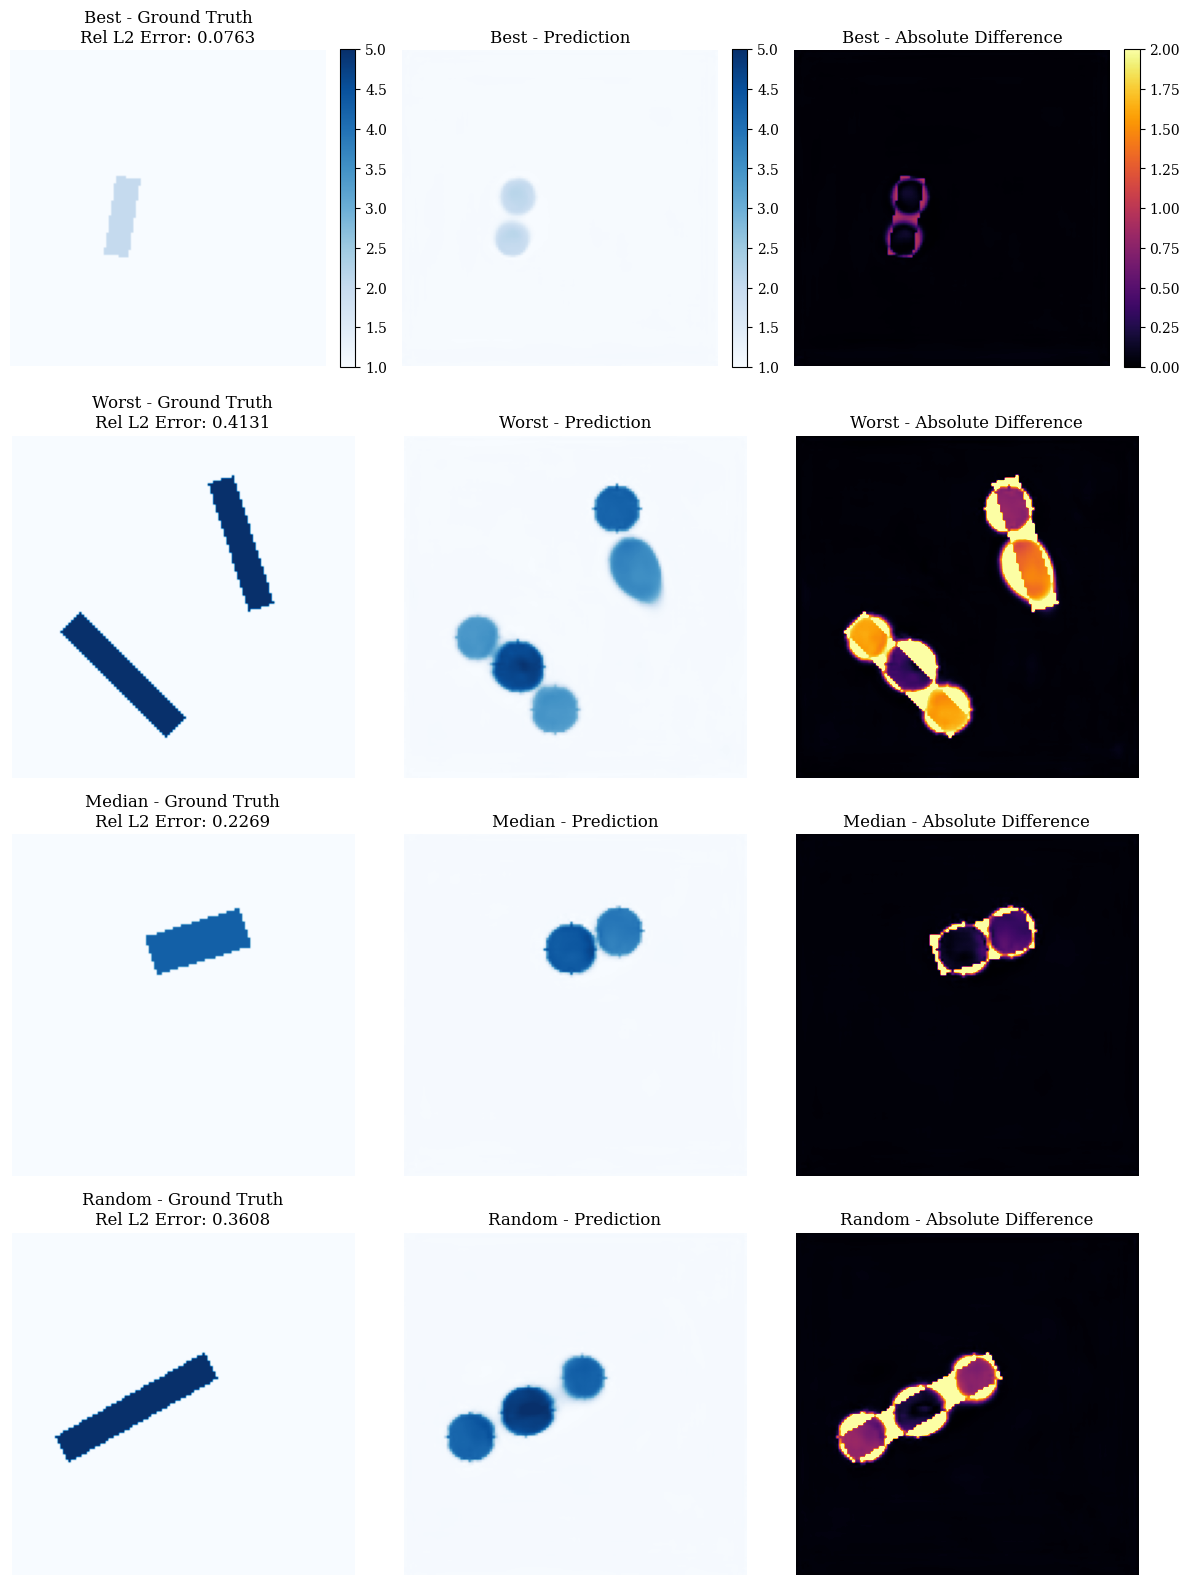

: 

In [ ]:
model.eval()
with torch.no_grad():
    test_ood_X = test_ood_X.to(device)
    # Run inference
    predictions = model(test_ood_X).squeeze(1)
    
    # Denormalize predictions
    predictions = 0.5 * (predictions + 1.0) * (train_Y_max - train_Y_min + 1e-12) + train_Y_min

    rel_l2_errors = []
    for i in range(len(predictions)):
        pred = predictions[i].cpu()
        gt = tubes_data['test']['media'][i].float().cpu()
        
        error = torch.norm(pred - gt, 2) / torch.norm(gt, 2)
        rel_l2_errors.append(error.item())
    
    rel_l2_errors = np.array(rel_l2_errors)
    
    # Print statistics
    print(f"OOD Relative L2 Error Statistics:")
    print(f"Mean: {rel_l2_errors.mean():.4f}")
    print(f"Std:  {rel_l2_errors.std():.4f}")
    print(f"Min:  {rel_l2_errors.min():.4f}")
    print(f"Max:  {rel_l2_errors.max():.4f}")
    print(f"Median: {np.median(rel_l2_errors):.4f}")
    
    plt.rcParams["font.family"] = "DejaVu Serif"
    title_font = {"family": "DejaVu Serif", "weight": "bold", "size": 12}

    # Find indices for visualization
    best_idx = np.argmin(rel_l2_errors)
    worst_idx = np.argmax(rel_l2_errors)
    median_idx = np.argsort(rel_l2_errors)[len(rel_l2_errors) // 2]
    random_idx = np.random.randint(len(rel_l2_errors))
    
    indices_to_plot = [best_idx, worst_idx, median_idx, random_idx]
    titles = ['Best', 'Worst', 'Median', 'Random']
    
    fig, axes = plt.subplots(4, 3, figsize=(12, 16))
    for i, (idx, title) in enumerate(zip(indices_to_plot, titles)):
        pred = predictions[idx].cpu().numpy()
        gt = tubes_data['test']['media'][idx].cpu().numpy()
        error = rel_l2_errors[idx]
        
        im1 = axes[i, 0].imshow(gt, cmap='Blues', vmin=1, vmax=5)
        axes[i, 0].set_title(f'{title} - Ground Truth\nRel L2 Error: {error:.4f}')
        axes[i, 0].axis('off')
        
        im2 = axes[i, 1].imshow(pred, cmap='Blues', vmin=1, vmax=5)
        axes[i, 1].set_title(f'{title} - Prediction')
        axes[i, 1].axis('off')
        
        diff = np.abs(pred - gt)
        im3 = axes[i, 2].imshow(diff, cmap='inferno', vmin=0, vmax=2)
        axes[i, 2].set_title(f'{title} - Absolute Difference')
        axes[i, 2].axis('off')
        
        if i == 0:
            fig.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
            fig.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)
            fig.colorbar(im3, ax=axes[0, 2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()